**Grupa 7 - Miłosz Lauda, Dominika, Bartosz**


*   Państwa starej Unii Europejskiej
*   Zmienna objaśniana: PKB per capita
*   Zmienne objaśniające: wskaźnik HDI, korupcja, wolność gospodarcza




## 1. Importowanie bibliotek

---

In [ ]:
!pip install linearmodels
!pip install pycountry
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare
from linearmodels.panel import RandomEffects

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.9 MB/s eta 0:00:00


## 2. Załadowanie danych

---

In [ ]:
df = pd.read_excel('/content/sample_data/TWG.xlsx')
print(df)

        Kraj   Rok    HDI  Korupcja  Wolność_gospodarcza    PKB_pc
0    Austria  1996  0.852      75.9                 74.0  29809.08
1    Austria  1997  0.856      76.1                 75.5  26705.48
2    Austria  1998  0.861      75.0                 75.6  27361.88
3    Austria  1999  0.865      76.0                 76.4  27183.48
4    Austria  2000  0.870      77.0                 77.1  24625.60
..       ...   ...    ...       ...                  ...       ...
373   Włochy  2018  0.894      52.0                 62.5  34622.17
374   Włochy  2019  0.899      53.0                 62.2  33673.75
375   Włochy  2020  0.892      53.0                 63.8  31922.92
376   Włochy  2021  0.899      56.0                 64.9  36441.06
377   Włochy  2022  0.906      56.0                 65.4  35068.84

[378 rows x 6 columns]


**Opis danych:**

**Kraj** - 14 państw starej Unii Europejskiej do których należą Austria, Belgia, Dania, Finlandia, Francja, Grecja, Hiszpania, Holandia, Irlandia, Luksemburg, Niemcy, Portugalia, Szwecja i Włochy.

**Rok** - lata 1996 - 2022

**Wskaźnik rozwoju społecznego HDI** ocenia poziom rozwoju krajów na podstawie trzech wymiarów: długości życia (średnia długość życia przy urodzeniu), edukacji (średnia liczba lat nauki dorosłych oraz przewidywana liczba lat nauki dzieci) oraz dochodów (PKB per capita w parytecie siły nabywczej). HDI przyjmuje wartość od 0 do 1, gdzie wyższe wartości wskazują na wyższy poziom rozwoju społecznego.

**Indeks Percepcji Korupcji** mierzy postrzeganą skalę korupcji w sektorze publicznym w krajach na całym świecie. Oparty jest na ocenach ekspertów i przedsiębiorców, którzy wyrażają swoje opinie na temat poziomu korupcji w administracji publicznej. Wartość indeksu wynosi od 0 do 100, gdzie 0 oznacza bardzo wysoką percepcję korupcji, a 100 oznacza brak korupcji.

**Wskaźnik wolności gospodarczej** jest miarą oceniającą stopień swobody, w jakim jednostki mogą działać w gospodarce danego kraju, w tym swobodę prowadzenia działalności gospodarczej, inwestycji, handlu międzynarodowego, a także stopień, w jakim rząd ingeruje w rynek i reguluje działalność gospodarczą. Jest to zmienna, która mierzy jakość i efektywność instytucji gospodarczych, takich jak systemy prawne, polityki publiczne, struktury rynkowe oraz regulacje państwowe. Skala wskaźnika mieści się w przedziale od 0 do 100, gdzie 0 oznacza całkowity brak wolności gospodarczej (pełna kontrola rządu i restrykcyjne regulacje), a 100 wskazuje na pełną wolność gospodarczą (brak ingerencji państwowych, minimalne regulacje, otwarty rynek).

**PKB per capita (Produkt Krajowy Brutto na mieszkańca)** to wskaźnik ekonomiczny, który mierzy wartość wszystkich dóbr i usług wytworzonych w danym kraju w określonym czasie, podzieloną przez liczbę mieszkańców tego kraju. Jest to miara standardu życia, która pozwala porównać poziom dobrobytu między różnymi krajami lub regionami. Wyższe PKB per capita zazwyczaj wskazuje na wyższy poziom życia i lepsze warunki ekonomiczne, chociaż nie uwzględnia on nierówności dochodowych.



## 3. Wykresy zmian wskaźników makroekonomicznych w krajach starej Unii Europejskiej (1996-2022)
---

In [ ]:
def calculate_percent_change(df, year1, year2):
    changes = {}
    for country in df['Kraj'].unique():
      country_data = df[(df['Kraj'] == country) & (df['Rok'].isin([year1, year2]))]
      if len(country_data) == 2:
          changes[country] = {}
          for col in ['HDI', 'Korupcja', 'Wolność_gospodarcza', 'PKB_pc']:
              val1 = country_data[country_data['Rok'] == year1][col].iloc[0]
              val2 = country_data[country_data['Rok'] == year2][col].iloc[0]
              if pd.notna(val1) and pd.notna(val2):
                changes[country][col] = (val2 - val1) / val1 * 100
              else:
                changes[country][col] = np.nan
      else:
        changes[country]={}
        for col in ['HDI', 'Korupcja', 'Wolność_gospodarcza', 'PKB_pc']:
            changes[country][col]=np.nan
    return changes

percent_changes = calculate_percent_change(df, 1996, 2022)


variable_dfs = {}
for var in ['HDI', 'Korupcja', 'Wolność_gospodarcza', 'PKB_pc']:
    var_df = pd.DataFrame({'Kraj': list(percent_changes.keys()),
                           f'{var}_Percent_Change': [percent_changes[country].get(var, np.nan)
                                                     for country in percent_changes]})
    var_df = var_df.sort_values(by=f'{var}_Percent_Change', ascending=False)
    variable_dfs[var] = var_df

hdi_df = variable_dfs['HDI']
corruption_df = variable_dfs['Korupcja']
economic_freedom_df = variable_dfs['Wolność_gospodarcza']
gdp_pc_df = variable_dfs['PKB_pc']

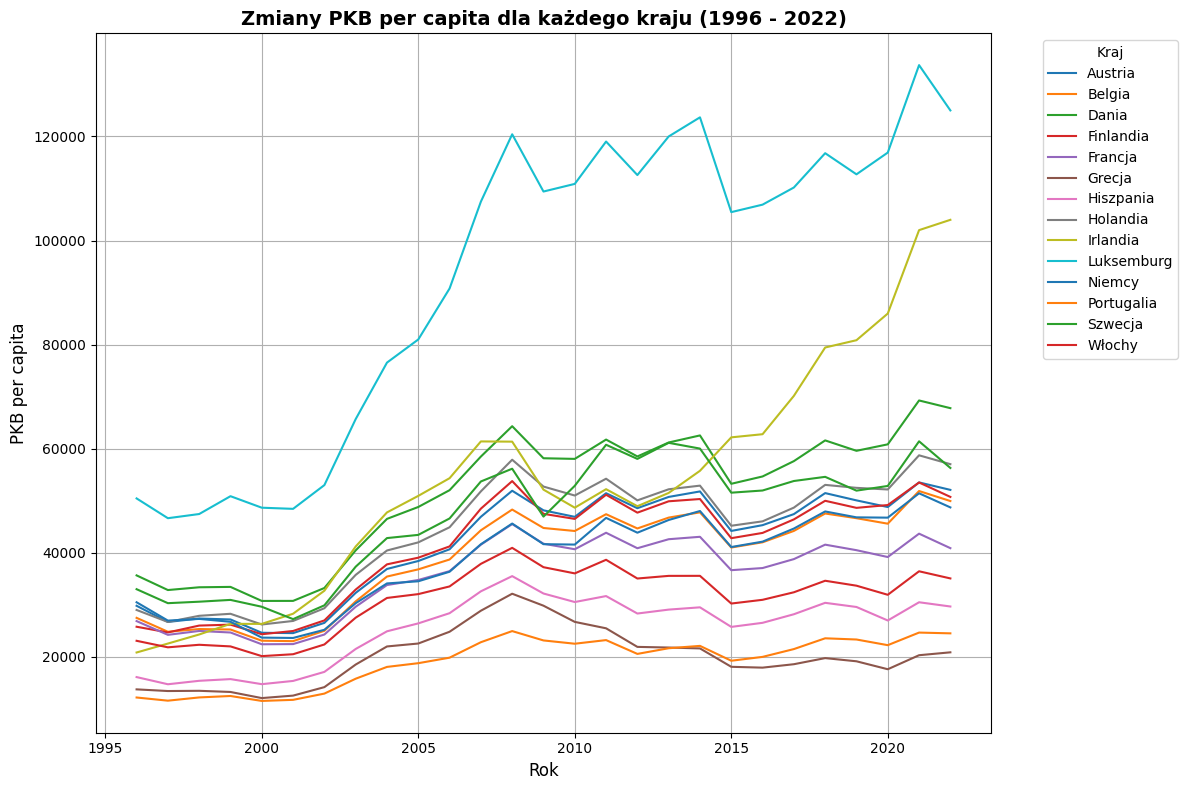

In [ ]:
plt.figure(figsize=(12, 8))

for country in df['Kraj'].unique():
    country_data = df[df['Kraj'] == country]
    plt.plot(country_data['Rok'], country_data['PKB_pc'], label=country)

plt.title('Zmiany PKB per capita dla każdego kraju (1996 - 2022)', fontsize=14,  fontweight='bold')
plt.xlabel('Rok', fontsize=12)
plt.ylabel('PKB per capita', fontsize=12)
plt.legend(title='Kraj', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

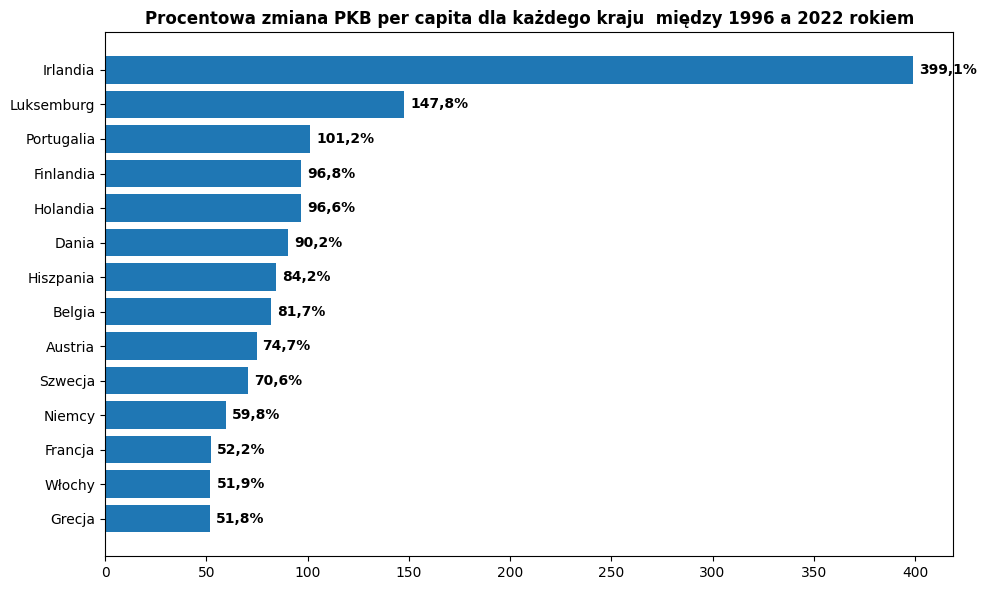

In [ ]:
gdp_pc_df_sorted = gdp_pc_df.sort_values(by=['PKB_pc_Percent_Change'], ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(gdp_pc_df_sorted['Kraj'], gdp_pc_df_sorted['PKB_pc_Percent_Change'])
plt.title('Procentowa zmiana PKB per capita dla każdego kraju  między 1996 a 2022 rokiem', fontweight='bold')

for i, v in enumerate(gdp_pc_df_sorted['PKB_pc_Percent_Change']):
    label = f"{round(v, 1):.1f}%".replace(".", ",")

    plt.text(v + 3, i, label, color='black', fontweight='bold', ha='left', va='center')

plt.tight_layout()
plt.show()

Wykresy przedstawiają zmiany wskaźnika PKB per capita w krajach starej Unii Europejskiej. Na pierwszym wykresie widać, że Irlandia wyróżnia się na tle innych krajów, wykazując znaczący wzrost PKB per capita, szczególnie od 2000 roku, osiągając drugie miejsce wsród liderów wzrostu PKB per capita. Luksemburg również pokazuje bardzo silny wzrost, zwłaszcza w ostatnich latach.
Drugi wykres, przedstawiający procentowe zmiany PKB per capita, potwierdza te obserwacje, wskazując na Irlandię jako lidera z niezwykłym wzrostem o 399,1%. Jest to skutkiem polityki fiskalnej Irlandii, która uważana jest za raj podatkowy, wskutek czego dużo międzynarodowych korporacji właśnie tam założyła swoje siedziby. Natomiast mimo okazałego wyniku ciężko mówić tu o wzroście poziomu życia Irlandczyków, gdyż mówi się, że PKB Irlandii jest sztucznie napompowane z wcześniej wymienionego powodu. Luksemburg z wynikiem 147,8% również wykazuje się dużą dynamiką, a inne kraje, takie jak Portugalia, Finlandia, Holandia i Dania notują solidne wzrosty na poziomie powyżej 90%.

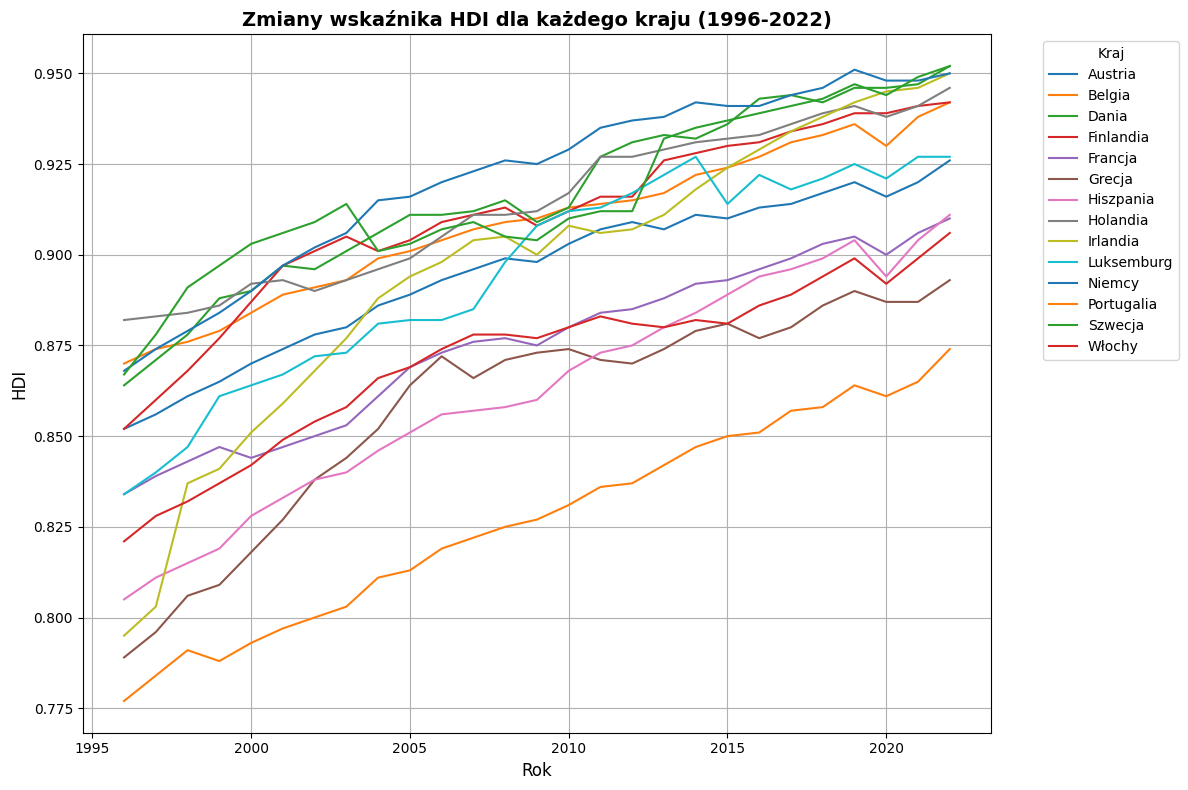

In [ ]:
plt.figure(figsize=(12, 8))

for country in df['Kraj'].unique():
    country_data = df[df['Kraj'] == country]
    plt.plot(country_data['Rok'], country_data['HDI'], label=country)

plt.title('Zmiany wskaźnika HDI dla każdego kraju (1996-2022)', fontsize=14, fontweight='bold')
plt.xlabel('Rok', fontsize=12)
plt.ylabel('HDI', fontsize=12)
plt.legend(title='Kraj', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

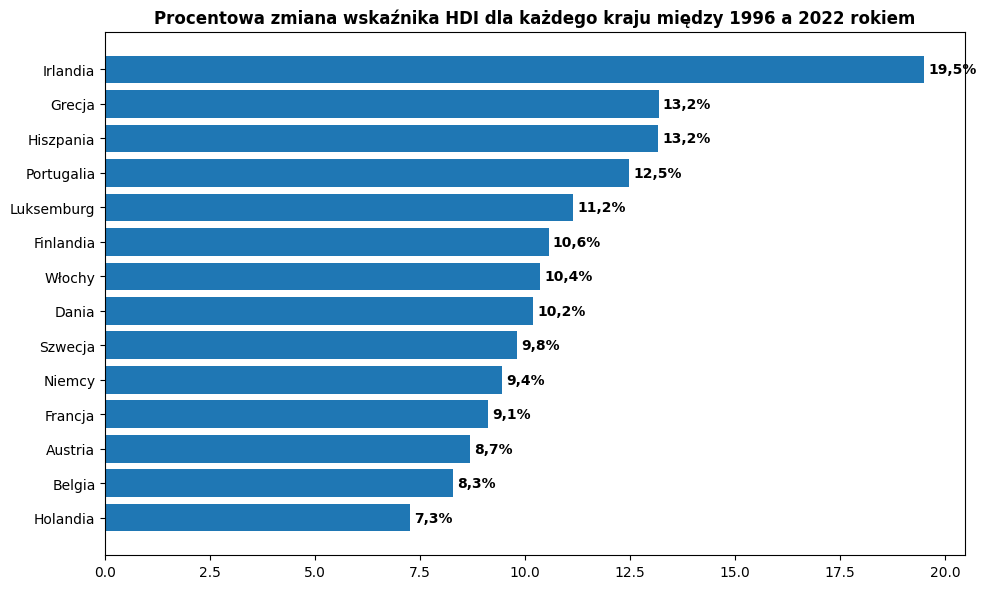

In [ ]:
hdi_df_sorted = hdi_df.sort_values(by=['HDI_Percent_Change'], ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(hdi_df_sorted['Kraj'], hdi_df_sorted['HDI_Percent_Change'])
plt.title('Procentowa zmiana wskaźnika HDI dla każdego kraju między 1996 a 2022 rokiem', fontweight='bold')

for i, v in enumerate(hdi_df_sorted['HDI_Percent_Change']):
    label = f"{round(v, 1):.1f}%".replace(".", ",")

    plt.text(v + 0.1, i, label, color='black', fontweight='bold', ha='left', va='center')

plt.tight_layout()
plt.show()

Wykresy przedstawiają zmiany wskaźnika HDI (Human Development Index) w krajach starej Unii Europejskiej. Na podstawie analizy widocznych trendów, można zauważyć, że Irlandia, która znajduje się na czołowej pozycji, odnotowała najwyższy wzrost HDI w tym okresie, osiągając wynik 19,5%. Kolejne kraje, takie jak Grecja, Hiszpania i Portugalia, również wykazały się znaczącym wzrostem, z wartościami w przedziale 12-13%. Wzrost ten może być związany z poprawą jakości życia, opieką zdrowotną, edukacją oraz innymi aspektami rozwoju społecznego, co przekłada się na lepsze warunki dla obywateli. Z drugiej strony, kraje takie jak Holandia, Belgia, Austria, Francja czy Niemcy wykazały mniejsze, ale wciąż stabilne zmiany, osiągając procentowe wzrosty na poziomie 7-10%. Tego typu informacje będą cenne w kontekście dalszych ekonometrycznych analiz, w których wskaźnik HDI będzie analizowany jako zmienna objaśniająca w stosunku do PKB p. c.

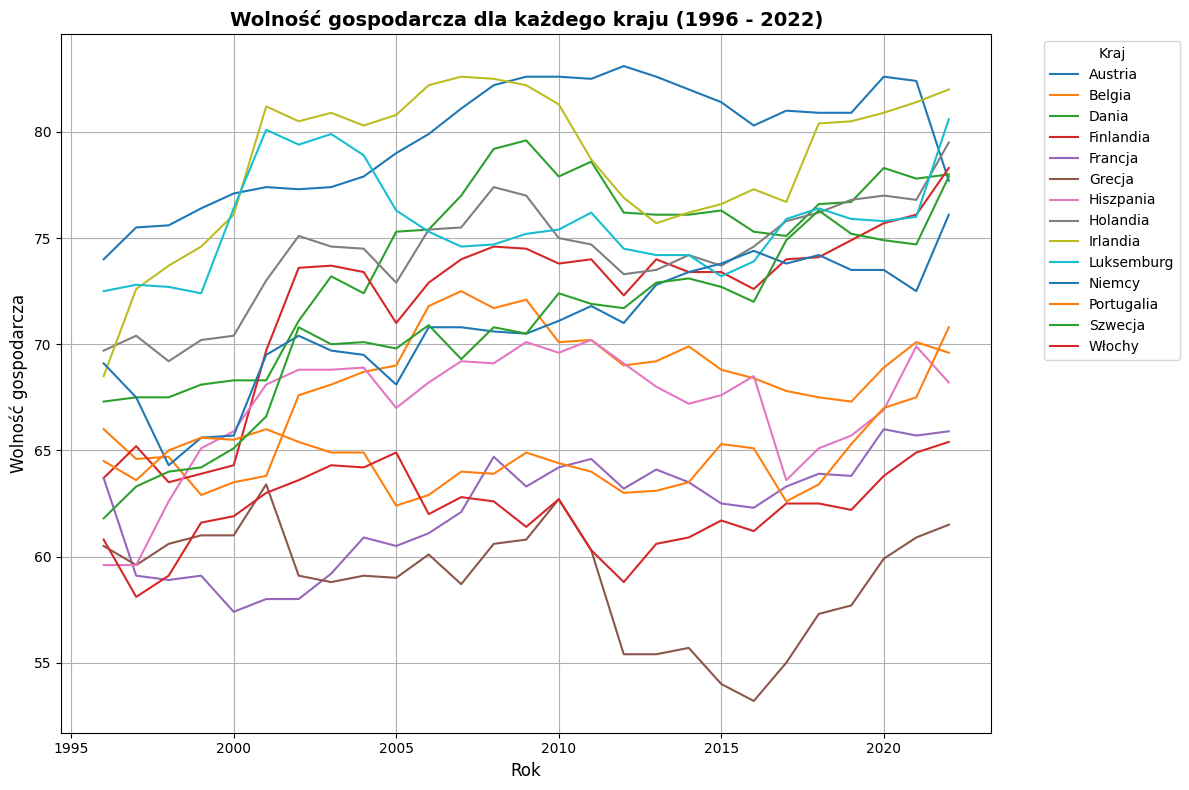

In [ ]:
plt.figure(figsize=(12, 8))

for country in df['Kraj'].unique():
    country_data = df[df['Kraj'] == country]
    plt.plot(country_data['Rok'], country_data['Wolność_gospodarcza'], label=country)

plt.title('Wolność gospodarcza dla każdego kraju (1996 - 2022)', fontsize=14, fontweight='bold')
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Wolność gospodarcza', fontsize=12)
plt.legend(title='Kraj', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

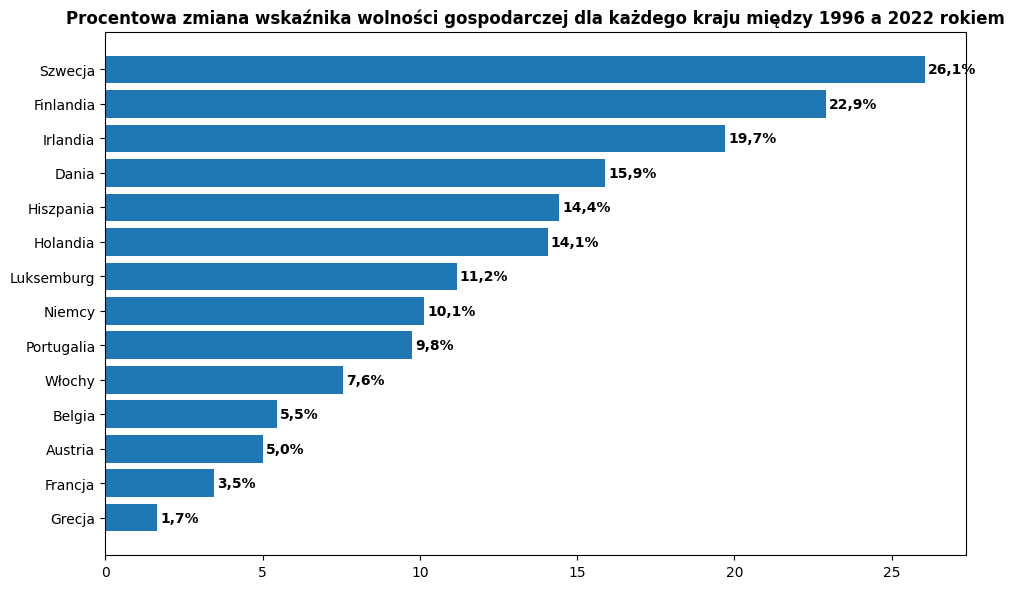

In [ ]:
economic_freedom_df_sorted = economic_freedom_df.sort_values(by=['Wolność_gospodarcza_Percent_Change'], ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(economic_freedom_df_sorted['Kraj'], economic_freedom_df_sorted['Wolność_gospodarcza_Percent_Change'])
plt.title('Procentowa zmiana wskaźnika wolności gospodarczej dla każdego kraju między 1996 a 2022 rokiem', fontweight='bold')

for i, v in enumerate(economic_freedom_df_sorted['Wolność_gospodarcza_Percent_Change']):
    label = f"{round(v, 1):.1f}%".replace(".", ",")

    plt.text(v + 0.1, i, label, color='black', fontweight='bold', ha='left', va='center')

plt.tight_layout()
plt.show()

Pierwszy wykres ilustruje zmiany wskaźnika wolności gospodarczej w czasie. Widać, że Irlandia wyróżnia się na tle innych krajów, osiągając najwyższy poziom wolności gospodarczej w 2022 roku. Finlandia, Dania, Hiszpania i Holandia również odnotowują znaczny wzrost tego wskaźnika, co wskazuje na poprawę klimatu gospodarczego w tych krajach. Wśród krajów o mniejszym wzroście znajdują się Włochy, Belgia, Austria, Francja i Grecja, które mają relatywnie stabilne poziomy wolności gospodarczej przez cały okres. Drugi wykres potwierdza te obserwacje. Szwecja osiągnęła najwyższą procentową zmianę na poziomie 26,1%, co świadczy o znaczącym postępie w poprawie wolności gospodarczej. Finlandia (22,9%) oraz Irlandia (19,7%) również wykazały się dużym wzrostem tego wskaźnika.

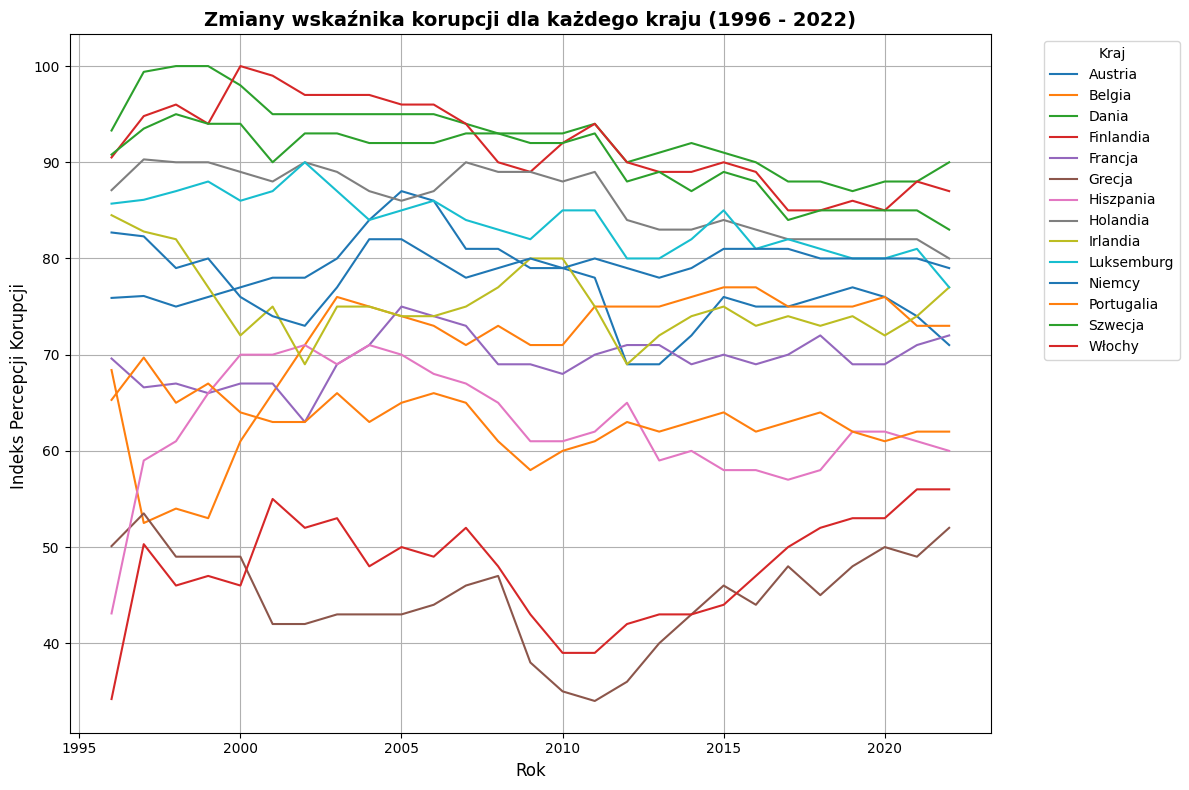

In [ ]:
plt.figure(figsize=(12, 8))

for country in df['Kraj'].unique():
    country_data = df[df['Kraj'] == country]
    plt.plot(country_data['Rok'], country_data['Korupcja'], label=country)

plt.title('Zmiany wskaźnika korupcji dla każdego kraju (1996 - 2022)', fontsize=14, fontweight='bold')
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Indeks Percepcji Korupcji ', fontsize=12)
plt.legend(title='Kraj', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

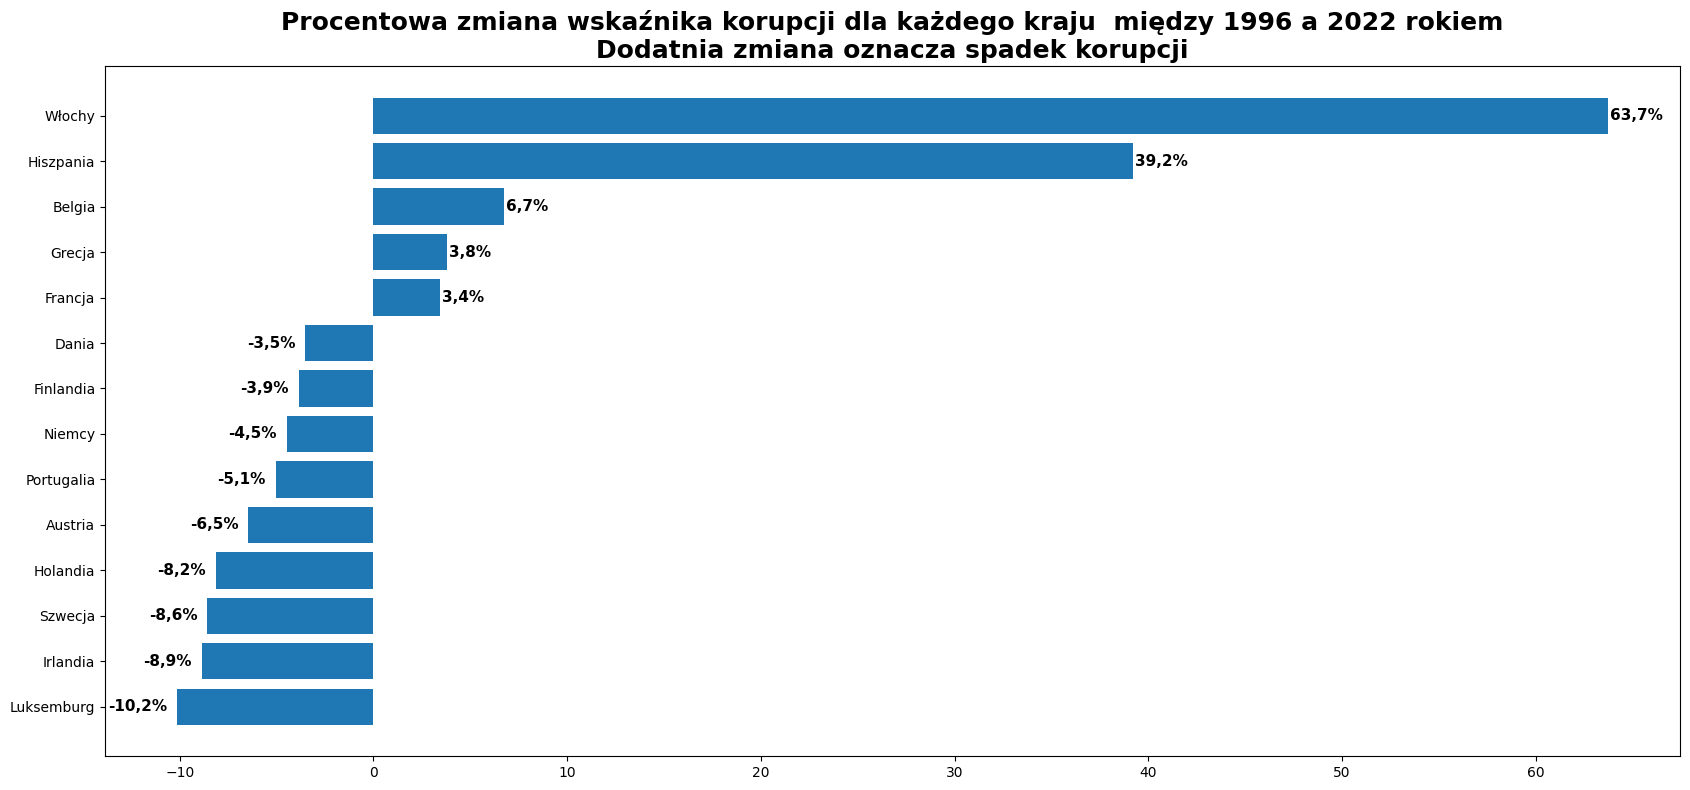

In [ ]:
corruption_df_sorted = corruption_df.sort_values(by=['Korupcja_Percent_Change'], ascending=True)

plt.figure(figsize=(17, 8))
plt.barh(corruption_df_sorted['Kraj'], corruption_df_sorted['Korupcja_Percent_Change'])
plt.title('Procentowa zmiana wskaźnika korupcji dla każdego kraju  między 1996 a 2022 rokiem\nDodatnia zmiana oznacza spadek korupcji', fontsize = 18, fontweight = 'bold')

for i, v in enumerate(corruption_df_sorted['Korupcja_Percent_Change']):
    label = f"{round(v, 1):.1f}%".replace(".", ",")

    if v >= 0:  # For positive values, position to the right
        plt.text(v + 0.1, i, label, color='black', fontweight='bold', ha='left', va='center', fontsize = 11)
    else:  # For negative values, position to the left
        plt.text(v - 0.5, i, label, color='black', fontweight='bold', ha='right', va='center', fontsize = 11)

plt.tight_layout()
plt.show()

Wysokie wartości indeksu wskazują na mniejszą percepcję korupcji (im wyższy wynik, tym mniej postrzeganej korupcji), a niskie na wyższy poziom korupcji. Z wykresu wynika, że kraje takie jak Szwecja, Dania, Finlandia czy Holandia wykazują stosunkowo stabilnie wysoki poziom wskaźnika, co oznacza niski poziom postrzeganej korupcji przez cały okres analizy. Z kolei kraje takie jak Włochy, Hiszpania czy Grecja miały niższe wartości wskaźnika, co może sugerować wyższy poziom postrzeganej korupcji. Na drugim wykresie przedstawiona jest procentowa zmiana wskaźnika korupcji, gdzie dodatnia zmiana oznacza spadek postrzeganego poziomu korupcji, a ujemna zmiana – wzrost tego poziomu. Włochy odnotowały największy wzrost o 63,7%, co wskazuje na znaczną poprawę w walce z korupcją i postrzeganiu tego zjawiska. Hiszpania również zanotowała wzrost o 39,2%, co również świadczy o poprawie. Z kolei kraje takie jak Luksemburg (-10,2%), Irlandia (-8,9%) czy Szwecja (-8,6%) doświadczyły spadku w indeksie, co moznacza wzrost postrzeganego poziomu korupcji w tych krajach.

# 4. Analiza skupień
---

**Analiza skupień (klasteryzacja)** krajów polega na grupowaniu państw o podobnych cechach w celu wykrycia naturalnych zależności i wzorców między nimi.

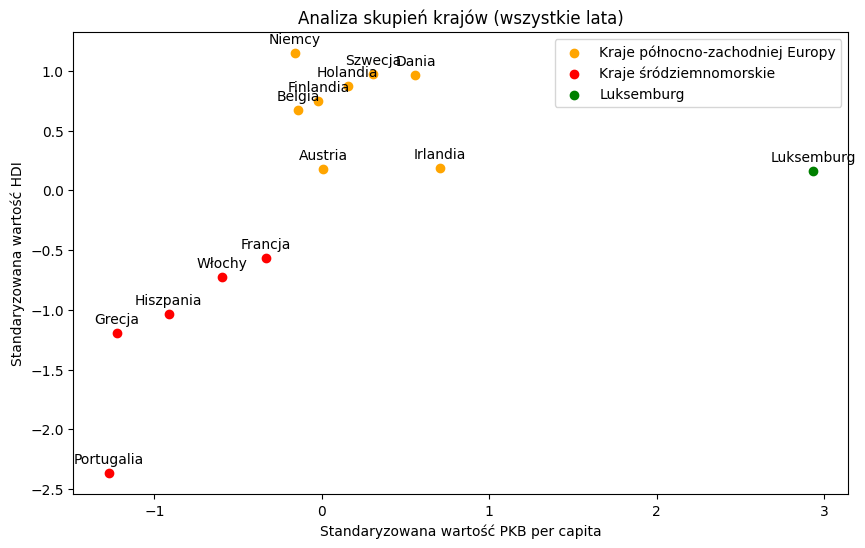

In [ ]:
X = df.groupby('Kraj')[['PKB_pc', 'HDI', 'Korupcja', 'Wolność_gospodarcza']].mean()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
X['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
colors = ['orange', 'red', 'green']

cluster_labels = ['Kraje północno-zachodniej Europy', 'Kraje śródziemnomorskie', 'Luksemburg']

for i in range(kmeans.n_clusters):
    plt.scatter(X_scaled[X['Cluster'] == i, 0], X_scaled[X['Cluster'] == i, 1], label=cluster_labels[i], c=colors[i % len(colors)])

for i, txt in enumerate(X.index):
    plt.annotate(txt, (X_scaled[i, 0], X_scaled[i, 1]), textcoords="offset points", xytext=(0,7), ha='center')

plt.title('Analiza skupień krajów (wszystkie lata)')
plt.xlabel('Standaryzowana wartość PKB per capita')
plt.ylabel('Standaryzowana wartość HDI')
plt.legend()
plt.show()

Na wykresie przedstawiono analizę skupień krajów na podstawie zmiennych takich jak PKB per capita, HDI, korupcja i wolność gospodarcza. Zastosowanie algorytmu KMeans z 3 grupami (klastrami) pozwoliło na podział krajów na trzy grupy, które są reprezentowane przez różne kolory: pomarańczowy (kraje północno-zachodniej Europy), czerwony (kraje śródziemnomorskie) i zielony (Luksemburg). Widać, że kraje takie jak Niemcy, Szwecja, Dania, Belgia i Irlandia znajdują się w jednym skupieniu, a kraje jak Portugalia, Hiszpania i Grecja w innym, co może świadczyć o różnicach w poziomie rozwoju gospodarczego i społecznego tych grup krajów. Luksemburg, który jest bardzo odrębny pod względem wskaźników, znajduje się w oddzielnym klastrze.


<ipython-input-13-bdfbb02f7b0f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1996['Klaster'] = kmeans_1996.fit_predict(data_1996_scaled)
<ipython-input-13-bdfbb02f7b0f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['Klaster'] = kmeans_2022.fit_predict(data_2022_scaled)


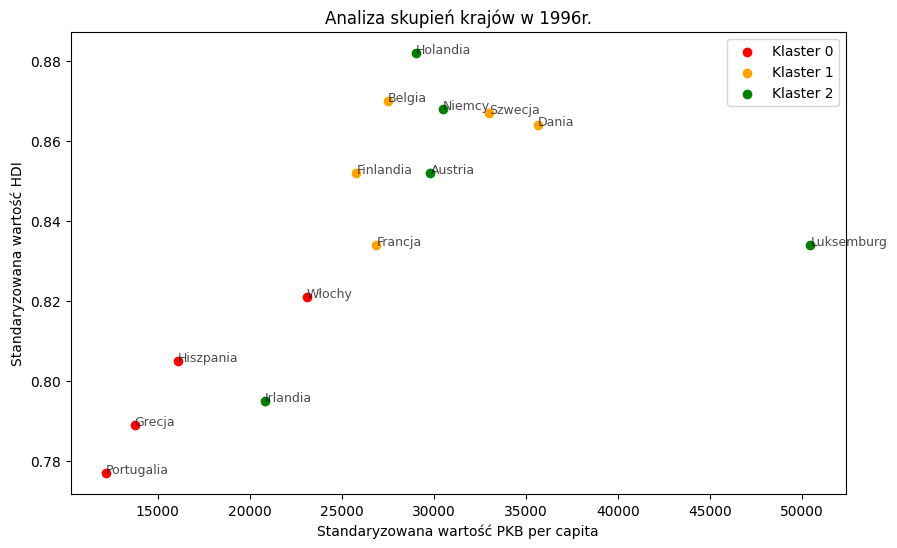

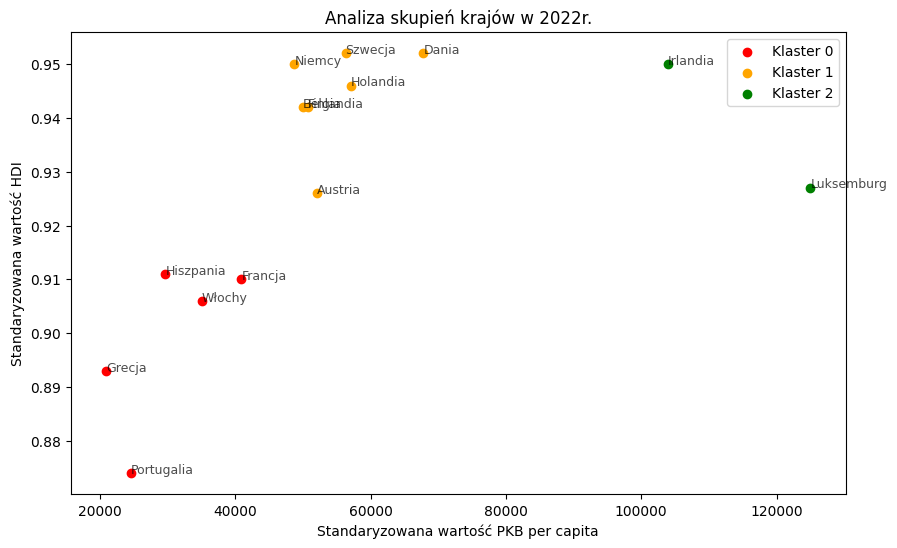

In [ ]:
df_1996 = df[df['Rok'] == 1996]
df_2022 = df[df['Rok'] == 2022]

data_1996 = df_1996[['PKB_pc', 'HDI', 'Wolność_gospodarcza', 'Korupcja']]
data_2022 = df_2022[['PKB_pc', 'HDI', 'Wolność_gospodarcza', 'Korupcja']]

scaler = StandardScaler()
data_1996_scaled = scaler.fit_transform(data_1996)
data_2022_scaled = scaler.transform(data_2022)

kmeans_1996 = KMeans(n_clusters=3, random_state=42)
kmeans_2022 = KMeans(n_clusters=3, random_state=42)

df_1996['Klaster'] = kmeans_1996.fit_predict(data_1996_scaled)
df_2022['Klaster'] = kmeans_2022.fit_predict(data_2022_scaled)

cluster_colors = ['red', 'orange', 'green']

# Rysowanie wykresów osobno dla lat 1996 i 2022

plt.figure(figsize=(10, 6))
for i in range(3):
    cluster_data_1996 = df_1996[df_1996['Klaster'] == i]
    plt.scatter(cluster_data_1996['PKB_pc'], cluster_data_1996['HDI'], color=cluster_colors[i], label=f'Klaster {i}')

for i in range(len(df_1996)):
    plt.text(df_1996['PKB_pc'].iloc[i], df_1996['HDI'].iloc[i], df_1996['Kraj'].iloc[i], fontsize=9, alpha=0.7)

plt.title('Analiza skupień krajów w 1996r.')
plt.xlabel('Standaryzowana wartość PKB per capita')
plt.ylabel('Standaryzowana wartość HDI')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(3):
    cluster_data_2022 = df_2022[df_2022['Klaster'] == i]
    plt.scatter(cluster_data_2022['PKB_pc'], cluster_data_2022['HDI'], color=cluster_colors[i], label=f'Klaster {i}')

for i in range(len(df_2022)):
    plt.text(df_2022['PKB_pc'].iloc[i], df_2022['HDI'].iloc[i], df_2022['Kraj'].iloc[i], fontsize=9, alpha=0.7)

plt.title('Analiza skupień krajów w 2022r.')
plt.xlabel('Standaryzowana wartość PKB per capita')
plt.ylabel('Standaryzowana wartość HDI')
plt.legend()
plt.show()

Na wykresach przedstawiających analizę skupień krajów według zmiennych takich jak PKB per capita, korupcja, wolność gospodarcza i HDI, z wizualizacją opartą na dwóch zmiennych – PKB per capita i HDI – widać zmiany w grupowaniu krajów pomiędzy rokiem 1996 a 2022. W 1996 roku, kraje zostały podzielone na trzy klastry. Klaster czerwony obejmował kraje o niskim PKB per capita i HDI, takie jak Portugalia, Grecja, Hiszpania oraz Włochy. Te kraje charakteryzowały się również wyższym poziomem korupcji oraz niższą wolnością gospodarczą. Klaster pomarańczowy był zdominowany przez kraje o wysokim wskaźniku HDI, jak Szwecja, Dania, Belgia, Finlandia i Francja które miały również niską korupcję i średnią wartość wskaźnika wolności gospodarczej. W klastrze zielonym znalazły się kraje o wysokich wartościach PKB per capita i HDI, takie jak Austria, Niemcy, Holandia, Irlandia oraz Luksemburg. Kraje charakteryzowały się również wysokim wskaźnikiem wolności gospodarczej i niższym poziomem korupcji.
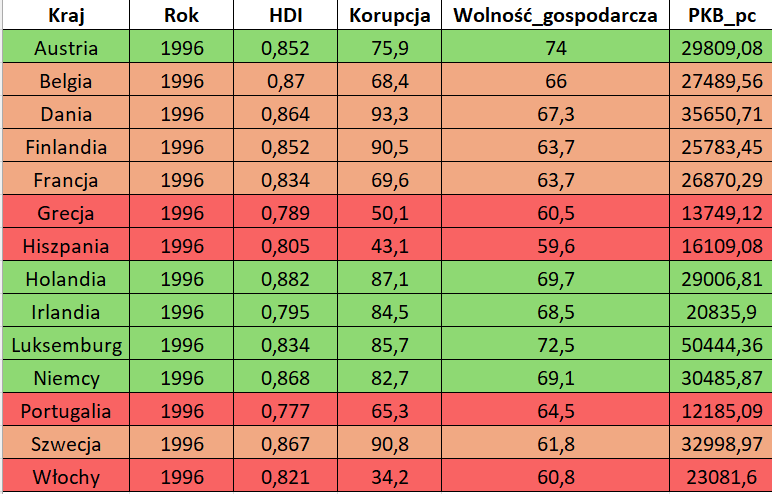

W 2022 roku, widać znaczną zmianę w grupowaniu krajów. Klaster czerwony nadal obejmował kraje o stosunkowo niskim PKB per capita i HDI, takie jak Portugalia, Grecja, Hiszpania, jednak ich sytuacja w porównaniu z krajami bardziej rozwiniętymi uległa pogorszeniu. Klaster pomarańczowy zyskał na znaczeniu, ponieważ kraje, które do niego należą takie Dania, Szwecja, Holandia, Niemcy, Belgia, Finlandia i Austria poprawiły swoje wyniki gospodarcze i społeczne, zwiększyły wolność gospodarczą i zmniejszyły korupcję. Klaster zielony zmniejszył się, obejmując tylko Irlandię i Luksemburg, które odnotowały znaczną poprawę pod względem wszystkich badanych wskaźników.  

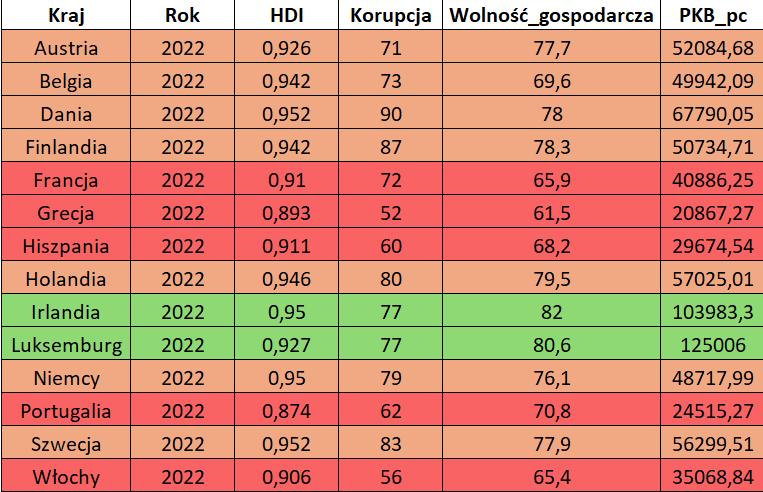

Podsumowując, w ciągu 26 lat widoczna jest poprawa w poziomie PKB per capita i HDI w krajach północnej i zachodniej Europy, natomiast kraje południowej Europy, mimo pewnych postępów, pozostały w tyle.

# 5. Model efektów stałych (Fixed Effects, FE)
Model efektów stałych (fixed effects model) jest techniką analizy danych panelowych, która zakłada, że efekty indywidualne są stałe w czasie i mogą być oszacowane. W tym modelu różnice pomiędzy jednostkami badawczymi są reprezentowane przez różne wartości stałych, co oznacza, że modeluje się te różnice jako parametry, które są specyficzne dla każdej jednostki, ale nie zmieniają się w czasie. Model efektów stałych można zapisać w postaci równania:

Yit​=αi​+βXit​+ϵit​

gdzie:

Yit​ to zmienna zależna dla jednostki i w czasie t,

αi​ to efekt stały dla jednostki i,

Xit​ to wektor zmiennych niezależnych,

β to wektor współczynników,

ϵit​ to składnik losowy.

In [ ]:
# Ustawienie indeksu dla danych panelowych: 'Kraj' i 'Rok'
df = df.set_index(['Kraj', 'Rok'])

In [ ]:
# Dopasowanie modelu z efektami stałymi
model = PanelOLS.from_formula('PKB_pc ~ HDI + Korupcja + Wolność_gospodarcza + EntityEffects', data=df)

EntityEffects dodaje do modelu zmienne fikcyjne (dummy) dla każdego kraju w danych panelowych, co pozwala na kontrolowanie różnic między krajami, które są stałe w czasie, a które mogą mieć wpływ na zmienną zależną (PKB per capita).

In [ ]:
# Dopasowanie modelu
results = model.fit()

In [ ]:
# Wyświetlenie wyników modelu
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 PKB_pc   R-squared:                        0.5997
Estimator:                   PanelOLS   R-squared (Between):             -37.021
No. Observations:                 378   R-squared (Within):               0.5997
Date:                Sat, Jan 25 2025   R-squared (Overall):             -34.158
Time:                        19:22:42   Log-likelihood                   -3942.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      180.28
Entities:                          14   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                   F(3,361)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):             180.28
                            

## **Interpretacja wyników**
### Podstawowe informacje:
- **Zmienne objaśniające**: HDI, Korupcja, Wolność gospodarcza
- **Zmienne objaśniane**: PKB per capita (PKB_pc)
- **Liczba obserwacji**: 378 (w sumie dla 14 jednostek – krajów, z danymi przez 27 okresów – lat).

### Szczegóły dla każdej zmiennej:
1. **HDI (Human Development Index)**:
   - **Współczynnik**: 3.266e+05 (326600)
   - **Błąd standardowy**: 2.009e+04 (20090)
   - **T-statystyka**: 16.257
   - **P-value**: 0.0000 (istotne statystycznie na poziomie 0.05)
   - **Przedział ufności**: [287100, 366100] (możemy być pewni, że rzeczywisty współczynnik leży w tym przedziale)
   
   HDI ma bardzo istotny wpływ na PKB per capita. Zwiększenie HDI o jednostkę prowadzi do wzrostu PKB per capita o około 326 600.

2. **Korupcja (Corruption)**:
   - **Współczynnik**: -198.69
   - **Błąd standardowy**: 104.57
   - **T-statystyka**: -1.9000
   - **P-value**: 0.0582 (granica istotności, prawie na poziomie 0.05)
   - **Przedział ufności**: [-404.34, 6.96]

  Wzrost wskaźnika korupcji o jednostkę (spadku korupcji) prowadzi do spadku PKB per capita o 198.69 jednostek. p-value na poziomie 0.0582 wskazuje, że wynik jest marginalnie istotny statystycznie, ale nie spełnia standardowego poziomu istotności 0.05. Przedział ufności (-404.34 do 6.96) sugeruje, że rzeczywisty wpływ może być bliski zeru, co podważa pewność tego wyniku.

3. **Wolność gospodarcza (Economic Freedom)**:
   - **Współczynnik**: 612.36
   - **Błąd standardowy**: 175.29
   - **T-statystyka**: 3.4935
   - **P-value**: 0.0005 (istotne statystycznie)
   - **Przedział ufności**: [267.65, 957.07]

   Wolność gospodarcza ma dodatni i istotny wpływ na PKB per capita. Zwiększenie wolności gospodarczej o jednostkę prowadzi do wzrostu PKB per capita o około 612.36.

### Test F dla Poolability:
- **F-test for Poolability**: 74.569
- **P-value**: 0.0000 (istotne statystycznie)

Test ten sprawdza, czy lepiej jest stosować model z efektami stałymi (FE) czy model pooled OLS. Wysoki wynik testu (i bardzo niski p-value) sugeruje, że model z efektami stałymi jest bardziej odpowiedni, ponieważ zmienne jednostkowe (np. krajowe różnice) mają istotny wpływ na wynik.

### R-squared:
- **R-squared**: 0.5997 - wskaźnik ten pokazuje, jaka część zmienności zmiennej zależnej (PKB_pc) jest wyjaśniona przez model. Model wyjaśnia około 60% zmienności.
- **R-squared (Between)**: -37.021 - pokazuje, jak dobrze zmienne niezależne wyjaśniają zmienność pomiędzy jednostkami; wartość ujemna może wskazywać na słabe dopasowanie w tej części modelu.
- **R-squared (Within)**: 0.5997 - wartość R-kwadratu dla zmienności wewnątrz jednostek, która w tym przypadku jest taka sama jak ogólny R-kwadrat, czyli 60%.
- **R-squared (Overall)**: -34.158 -ogólny wskaźnik R-kwadratu, który wskazuje na słabe dopasowanie modelu do wszystkich danych.

### F-statistic:
- **F-statistic**: 180.28 (Wartość statystyki F wskazuje, że model jest istotny statystycznie, ponieważ jest znacznie wyższa niż wartość krytyczna.)
- **p-value**: 0.0000 (p-wartość wskazuje na to, że model jest istotny statystycznie)

### Podsumowanie:
- Model pokazuje istotny wpływ HDI i Wolności gospodarczej na PKB per capita. Korupcja ma wpływ, ale jest to wynik graniczny.
- Model efektów stałych jest odpowiedni, ponieważ test poolability wskazuje na istotne różnice między jednostkami.



# 6. Model efektów losowych (Random Effects, RE)

Model efektów losowych (Random Effects Model) jest techniką analizy danych panelowych, która traktuje efekty indywidualne jako część składnika losowego. W przeciwieństwie do modelu efektów stałych, w którym efekty są traktowane jako stałe dla jednostek, model efektów losowych zakłada, że efekty te są losowe i pochodzą z większej populacji. Taki model jest użyteczny, gdy różne poziomy zmiennej objaśniającej są traktowane jako próbki z populacji, co pozwala na uwzględnienie zmienności między jednostkami oraz w obrębie jednostek.Model efektów losowych można zapisać w postaci równania:

Yit​=α+Xit​β+ui​+ϵit​

Yit​ to zmienna zależna dla jednostki i w czasie t,

α to stała (wyraz wolny),

Xit​ to wektor zmiennych niezależnych,

β to wektor współczynników,

ui​ to efekt losowy dla jednostki ii, który jest traktowany jako zmienna losowa z rozkładu normalnego,

ϵit​ to składnik losowy, który również jest zmienną losową.

---

In [ ]:
model_re = RandomEffects.from_formula('PKB_pc ~ HDI + Korupcja + Wolność_gospodarcza', data=df)
results_re = model_re.fit()
print(results_re.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 PKB_pc   R-squared:                        0.3998
Estimator:              RandomEffects   R-squared (Between):              0.6080
No. Observations:                 378   R-squared (Within):               0.3702
Date:                Sat, Jan 25 2025   R-squared (Overall):              0.5899
Time:                        19:22:42   Log-likelihood                   -4043.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      83.256
Entities:                          14   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                   F(3,375)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):             83.256
                            

## **Interpretacja wyników**

### Podstawowe informacje:
- **Zmienne objaśniające**: HDI, Korupcja, Wolność gospodarcza
- **Zmienne objaśniane**: PKB per capita (PKB_pc)
- **Liczba obserwacji**: 378 (w sumie dla 14 jednostek – krajów, z danymi przez 27 okresów – lat).

### Szczegóły dla każdej zmiennej:

1. **HDI (Human Development Index)**:
   - **Współczynnik**: 1.065e+05 (106 500)
   - **Błąd standardowy**: 1.811e+04 (18110)
   - **T-statystyka**: 5.8822
   - **P-value**: 0.0000 (istotne statystycznie na poziomie 0.05)
   - **Przedział ufności**: [70910, 142100]
   
   HDI ma bardzo istotny wpływ na PKB per capita. Zwiększenie HDI o jednostkę prowadzi do wzrostu PKB per capita o około 106 500.

2. **Korupcja (Corruption)**:
  - **Współczynnik**: -997.61
  - **Błąd standardowy**: 104.93
  - **T-statystyka**: -9.5071
  - **P-value**: 0.0000
  - **Przedział ufności**: [-1203.9, -791.28]

  Wzrost wkaźnika korupcji o jedną jednostkę (spadek korupcji) obniża PKB_pc o około 997.61 jednostek.

3. **Wolność gospodarcza (Economic Freedom)**:
   - **Współczynnik**: 488.90
   - **Błąd standardowy**: 219.92
   - **T-statystyka**: 2.2231
   - **P-value**: 0.0268
   - **Przedział ufności**: [56.472, 921.33]

   Wolność gospodarcza pozytywnie wpływa na PKB_pc, choć jej wpływ jest mniejszy w porównaniu z HDI. Zwiększenie wolności gospodarczej o jednostkę prowadzi do wzrostu PKB per capita o około 488.90.

### R-squared:
- **R-squared**: 0.3998 - model wyjaśnia około 40% zmienności zmiennej zależnej.

- **R-squared (Within)**: 0.3702 - 37,02% zmienności wewnątrz jednostek (np. krajów lub regionów) jest wyjaśnione przez zmienne niezależne.
- **R-squared (Between)**: 0.6080 - model lepiej wyjaśnia różnice między jednostkami, ponieważ 60,80% wariancji między jednostkami jest wyjaśnione przez zmienne.
- **R-squared (Overall)**: 0.5899  - model wyjaśnia około 58,99% wariancji w PKB_pc. Jest to dość dobre dopasowanie modelu.


F-statystyka (83.256, p = 0.0000) - cały model jest istotny statystycznie, co oznacza, że przynajmniej jedna zmienna niezależna ma istotny wpływ na PKB_pc.

### Podsumowanie:

* Model wskazuje, że wysoki poziom rozwoju społecznego (HDI) oraz wolność gospodarcza mają pozytywny wpływ na PKB_pc.
* Wyższy poziom korupcji (mniejsza korupcja) istotnie i negatywnie wpływa na PKB_pc. Model dobrze dopasowuje się do danych (ogólny R-squared wynosi 58,99%), a wszystkie zmienne są istotne statystycznie.

# 7. Porównanie modeli

---



In [ ]:
print(compare({'FE': results, 'RE': results_re}))

                    Model Comparison                    
                                    FE                RE
--------------------------------------------------------
Dep. Variable                   PKB_pc            PKB_pc
Estimator                     PanelOLS     RandomEffects
No. Observations                   378               378
Cov. Est.                   Unadjusted        Unadjusted
R-squared                       0.5997            0.3998
R-Squared (Within)              0.5997            0.3702
R-Squared (Between)            -37.021            0.6080
R-Squared (Overall)            -34.158            0.5899
F-statistic                     180.28            83.256
P-value (F-stat)                0.0000            0.0000
=====================     ============   ===============
HDI                          3.266e+05         1.065e+05
                              (16.257)          (5.8822)
Korupcja                       -198.69           -997.61
                             (-

# 8. Test Hausmana

Test Hausmana jest narzędziem statystycznym stosowanym do weryfikacji hipotezy o egzogeniczności zmiennych w modelach ekonometrycznych. Jego głównym celem jest porównanie dwóch estymatorów parametrów: jednego, który jest efektywny, ale może być obciążony (np. estymator OLS), oraz drugiego, który jest zgodny, ale mniej efektywny (np. estymator z wykorzystaniem zmiennych instrumentalnych).

Hipotezy testu Hausmana

- Hipoteza zerowa (H0): Estymatory są zgodne i nie ma błędów specyfikacji
- Hipoteza alternatywna (H1): Estymatory są niezgodne, co wskazuje na błędy specyfikacji

Statystyka testu Hausmana jest definiowana jako:

H=(β^​2​−β^​1​)′⋅(Var(β^​2​)−Var(β^​1​))−1⋅(β^​2​−β^​1​)

gdzie:

- β^1​ to estymator bardziej efektywny,
- β^2 to estymator mniej efektywny,
- H ma rozkład chi-kwadrat z odpowiednią liczbą stopni swobody
---

In [ ]:
b_fe = results.params
b_re = results_re.params
var_fe = results.cov
var_re = results_re.cov

var_fe_np = var_fe.to_numpy()
var_re_np = var_re.to_numpy()

# Test statystyczny
stat = (b_fe - b_re).T @ np.linalg.inv(var_fe_np - var_re_np) @ (b_fe - b_re)
df_stat = b_fe.size  # Stopnie swobody
p_value = chi2.sf(stat, df_stat)

# Wyniki
print("Statystyka testu Hausmana:", stat)
print("P-wartość:", p_value)

if p_value < 0.05:
    print("Wybierz model efektów stałych (FE).")
else:
    print("Wybierz model efektów losowych (RE).")

Statystyka testu Hausmana: 215.99577970449187
P-wartość: 1.4732347555873708e-46
Wybierz model efektów stałych (FE).


## **Interpretacja wyników**

* **Statystyka testu Hausmana**: 215.99

  - Wysoka wartość statystyki oznacza dużą różnicę między współczynnikami oszacowanymi w modelach FE i RE. To sugeruje, że założenie modelu RE o braku korelacji między zmiennymi objaśniającymi a składnikiem losowym nie jest spełnione.

* **P-value**: 1.47e-46
  - Bardzo niska p-wartość (praktycznie 0) wskazuje na istotność różnicy między modelami. Przy standardowym poziomie istotności (np. 0.05) wybierasz model efektów stałych.

* Co oznacza wybór FE?

  - Model efektów stałych lepiej kontroluje różnice charakterystyczne dla krajów, które są stałe w czasie, eliminując potencjalne uprzedzenia wynikające z tych różnic.

# 9. Model efektów mieszanych (Mixed Effects, ME)

Model efektów mieszanych (mixed effects model) jest rozszerzeniem tradycyjnych modeli regresyjnych, które uwzględniają zarówno efekty stałe, jak i losowe. Modele te są szczególnie przydatne w analizie danych o strukturze hierarchicznej lub grupowej, gdzie obserwacje są powiązane w ramach grup (np. pomiary powtarzane na tych samych jednostkach).

Ogólną postać liniowego modelu efektów mieszanych można przedstawić jako:

yij=β0+b0i+β1xij+ϵij

gdzie:

- yij​ – zmienna zależna (objaśniana),
- xij​ – zmienna niezależna (objaśniająca),
- β0​ – stały parametr modelu (efekt stały),
- b0i​ – losowy parametr modelu (efekt losowy dla i-tej grupy),
- ϵij​ – błąd pomiaru (reszty modelu).

---

In [ ]:
me = mixedlm("PKB_pc ~ HDI + Korupcja + Wolność_gospodarcza -1", df, groups=df.index.get_level_values(0))
results_me = me.fit()
print(results_me.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        PKB_pc       
No. Observations:          378            Method:                    REML         
No. Groups:                14             Scale:                     70315717.3710
Min. group size:           27             Log-Likelihood:            -3998.7072   
Max. group size:           27             Converged:                 Yes          
Mean group size:           27.0                                                   
----------------------------------------------------------------------------------
                         Coef.        Std.Err.    z    P>|z|   [0.025     0.975]  
----------------------------------------------------------------------------------
HDI                      312475.061   20519.580 15.228 0.000 272257.424 352692.699
Korupcja                   -261.362     106.198 -2.461 0.014   -469.506    -53.218
Wolność_gospodarcza        

## **Interpretacja wyników**
### Podstawowe informacje:
- **Zmienne objaśniane**:
 - **PKB_pc** - PKB per capita – wartość produktu krajowego brutto na mieszkańca.
- **Zmienne objaśniające**:
  - **HDI** (Human Development Index) – indeks rozwoju społecznego.
  - **Korupcja** – wskaźnik korupcji (wyższa wartość oznacza mniej korupcji).
  - **Wolność_gospodarcza** – indeks wolności gospodarczej.

### Szczegóły dla każdej zmiennej:  
1. **HDI (Human Development Index)**:
   - **Współczynnik**: 312475.061 – wzrost indeksu HDI o jednostkę wiąże się z wzrostem PKB per capita o około 312 475 jednostek.
   - **Błąd standardowy**: 20519.58
   - **Z-statystyka**: 15.228 – bardzo wysoka wartość.
   - **P-value**: 0.000 – wynik jest istotny statystycznie na poziomie 0.05.
   - **Przedział ufności**: [272257.424, 352692.699] – rzeczywisty wpływ mieści się w tym zakresie z 95% pewnością.

   HDI ma bardzo silny, dodatni i istotny wpływ na PKB per capita.

2. **Korupcja**:
   - **Współczynnik**: -261.362 – wzrost wskaźnika korupcji (mniej korupcji) wiąże się z spadkiem PKB per capita o 261.362 jednostek.
   - **Błąd standardowy**: 106.198
   - **Z-statystyka**: -2.461 – wynik wskazuje na umiarkowaną siłę związku.
   - **P-value**: 0.014 – wynik jest istotny statystycznie.
   - **Przedział ufności**: [-469.506, -53.218]

   Mniejsza korupcja (wyższy wskaźnik) jest związana ze spadkiem PKB per capita.

3. **Wolność gospodarcza**:
   - **Współczynnik**: 597.054 – wzrost wolności gospodarczej o jednostkę wiąże się z wzrostem PKB per capita o około 597 jednostek.
   - **Błąd standardowy**: 175.564
   - **Z-statystyka**: 3.401 – wysoka wartość.
   - **P-value**: 0.001 – wynik istotny statystycznie.
   - **Przedział ufności**: [252.956, 941.153]

   Wolność gospodarcza ma dodatni i istotny wpływ na PKB per capita.

**Log-Likelihood**: -3998.7072 – miara dopasowania modelu, używana do porównywania modeli.

**Group Var**: 67 439 418 587,766 – wariancja między krajami. Wskazuje na zróżnicowanie wpływu zmiennych między jednostkami.

### Podsumowanie:
- **HDI** i **Wolność gospodarcza** mają silny, pozytywny wpływ na PKB per capita i są istotne statystycznie.
- **Korupcja** ma negatywny wpływ na PKB per capita. Wynik jest istotny statystycznie, ale wymaga głębszej analizy, aby zrozumieć mechanizm tego związku.
- Model uwzględnia zmienność między jednostkami, co jest ważne w analizie danych panelowych.

